In [1]:
import glob
from pathlib import Path
from xml.etree.ElementTree import ElementTree
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import savgol_filter

In [2]:
def coords_to_offsets(coords):
    """
    convert from coordinates to offsets
    """
    offsets = np.concatenate([coords[1:, :2] - coords[:-1, :2], coords[1:, 2:3]], axis=1)
    offsets = np.concatenate([np.array([[0, 0, 1]]), offsets], axis=0)
    return offsets

In [3]:
def align(coords):
    """
    corrects for global slant/offset in handwriting strokes
    """
    coords = np.copy(coords)
    X, Y = coords[:, 0].reshape(-1, 1), coords[:, 1].reshape(-1, 1)
    X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)
    offset, slope = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y).squeeze()
    theta = np.arctan(slope)
    rotation_matrix = np.array(
        [[np.cos(theta), -np.sin(theta)],
         [np.sin(theta), np.cos(theta)]]
    )
    coords[:, :2] = np.dot(coords[:, :2], rotation_matrix) - offset
    return coords

In [4]:
def denoise(coords):
    """
    smoothing filter to mitigate some artifacts of the data collection
    """
    coords = np.split(coords, np.where(coords[:, 2] == 1)[0] + 1, axis=0)
    new_coords = []
    for stroke in coords:
        if len(stroke) != 0:
            x_new = savgol_filter(stroke[:, 0], 7, 3, mode='nearest')
            y_new = savgol_filter(stroke[:, 1], 7, 3, mode='nearest')
            xy_coords = np.hstack([x_new.reshape(-1, 1), y_new.reshape(-1, 1)])
            stroke = np.concatenate([xy_coords, stroke[:, 2].reshape(-1, 1)], axis=1)
            new_coords.append(stroke)

    coords = np.vstack(new_coords)
    return coords

In [5]:
def normalize(offsets):
    """
    normalizes strokes to median unit norm
    """
    offsets = np.copy(offsets)
    offsets[:, :2] /= np.median(np.linalg.norm(offsets[:, :2], axis=1))
    return offsets

In [19]:
def draw(
    offsets,
    align_strokes=True,
    denoise_strokes=True,
    ascii_seq=None
):
    strokes = offsets

    fig, ax = plt.subplots(figsize=(12, 3))

    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], -np.asarray(coords[1]), 'k', c='blue')
            stroke = []

    if stroke:
        coords = zip(*stroke)
        ax.plot(coords[0], -np.asarray(coords[1]), 'k', c='blue')
        stroke = []

    ax.set_xlim(-50, 600)
    ax.set_ylim(-40, 40)
  
    ax.set_aspect('equal')
    plt.tick_params(
        axis='both',
        left='off',
        top='off',
        right='off',
        bottom='off',
        labelleft='off',
        labeltop='off',
        labelright='off',
        labelbottom='off'
    )

    if ascii_seq is not None:
        if not isinstance(ascii_seq, str):
            ascii_seq = ''.join(list(map(chr, ascii_seq)))
        plt.title(ascii_seq)

### 1. Retrieve all text files

In [20]:
files = glob.glob("/data/iam_ondb/ascii/**/*.txt", recursive=True)
print("Printing sample filename: ")
print(files[0])

Printing sample filename: 
/data/iam_ondb/ascii/p07/p07-909/p07-909z.txt


In [21]:
sentences = []
lineStrokes = []

In [22]:
# for i, file in enumerate(files):
root = Path(files[0])
data = open(root).read().splitlines()
start_idx = data.index('CSR:') + 2
text = data[start_idx:]
sentences += text

# for i in range(1, 1 + len(text)):
i=1
stroke_path = str(root).replace('ascii', 'lineStrokes').replace('.txt', '-%02d.xml' % i)
et = ElementTree().parse(stroke_path)
arr = []
for stroke in et[1]: # loop through Strokes in a StrokeSet
    for point in stroke: # loop through points in a Stroke
        arr.append([int(point.attrib['x']), int(point.attrib['y']), 0])
    arr[-1][-1] = 1 # Stroke ends, pen up!

In [23]:
points = np.array(arr)
points = denoise(align(points))
# points = denoise(points)
diffs = coords_to_offsets(points)
diffs = normalize(diffs)

In [24]:
recons_points = np.concatenate([np.cumsum(diffs[:, :2], 0), diffs[:, 2:3]], 1)

In [25]:
recons_points

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.09267596e-02, 5.46337979e-02, 0.00000000e+00],
       [1.09267596e-01, 1.61169704e-01, 0.00000000e+00],
       ...,
       [3.88490010e+02, 4.10299822e+00, 0.00000000e+00],
       [3.89022690e+02, 4.42806932e+00, 0.00000000e+00],
       [3.89129226e+02, 4.66572634e+00, 1.00000000e+00]])

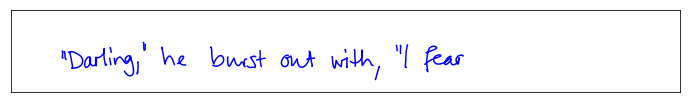

In [26]:
draw(recons_points)

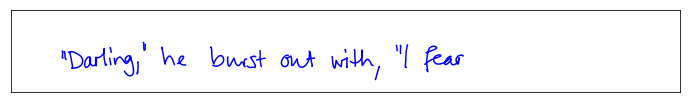

In [27]:
draw(recons_points)

In [28]:
sentences[i-1]

'"Darling," he burst out with, "I fear'